# Project - Income Prediction using Adult Census Data  

#### Kacper Hołowaty - May 15, 2024

## 1. Introduction

In this project, I decided to use the database available here: [Adult Census Income](https://www.kaggle.com/datasets/uciml/adult-census-income/data) which presents data regarding people's earnings (whether they are above or below 50k), depending on their origin, marital status, gender, etc. The goal of the project was to test various classification techniques/models, trying to achieve the highest classification score.

## 2. Database

### Brief description of all database columns (only those I used)
- **age**: Person's age
- **workclass**: Type of employment
- **education.num**: Education level represented numerically
- **marital.status**: Marital status
- **occupation**: Occupation performed by the person
- **relationship**: Relationship with another person in the family
- **race**: Person's race
- **sex**: Person's gender
- **hours.per.week**: Number of working hours per week
- **native.country**: Country of origin
- **income**: Annual income

In accordance with what I wrote previously, the goal is to recognize how much a person earns (i.e., predicting the value of the income column).

## 3. Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [2]:
df = pd.read_csv("adult.csv")

print(df)
print(df.describe())

       age workclass  fnlwgt     education  education.num      marital.status  \
0       90         ?   77053       HS-grad              9             Widowed   
1       82   Private  132870       HS-grad              9             Widowed   
2       66         ?  186061  Some-college             10             Widowed   
3       54   Private  140359       7th-8th              4            Divorced   
4       41   Private  264663  Some-college             10           Separated   
...    ...       ...     ...           ...            ...                 ...   
32556   22   Private  310152  Some-college             10       Never-married   
32557   27   Private  257302    Assoc-acdm             12  Married-civ-spouse   
32558   40   Private  154374       HS-grad              9  Married-civ-spouse   
32559   58   Private  151910       HS-grad              9             Widowed   
32560   22   Private  201490       HS-grad              9       Never-married   

              occupation   

I noticed that there are quite a few missing data points in the database. They are marked with "?". The code below first transforms this data into `None` values, and then fills these empty spaces with the most frequently occurring values in the given column. We can do this because "?" occurs only in columns with `string` type data.

In [5]:
df.replace("?", pd.NA, inplace=True)
print(df.isnull().sum())
for column in df.columns:
  if df[column].dtype == 'object':  
    most_common_value = df[column].mode()[0]
    df[column].fillna(most_common_value, inplace=True)

print()
print(df.isnull().sum())

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


C:\Users\kacpe\AppData\Local\Temp\ipykernel_19096\274996765.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(most_common_value, inplace=True)


The next step was to convert all non-numeric values to numeric ones and then extract those columns that I will use for classification.

In [6]:
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
df['marital.status'] = df['marital.status'].replace(['Never-married', 'Divorced', 'Separated', 'Widowed'], 'Single')
df['marital.status'] = df['marital.status'].replace(['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'], 'Married')
df['marital.status'] = df['marital.status'].map({'Married': 1, 'Single': 0})

df['occupation'] = df['occupation'].replace(['Prof-specialty', 'Exec-managerial', 'Tech-support'], 'White-collar')
df['occupation'] = df['occupation'].replace(['Craft-repair', 'Machine-op-inspct', 'Transport-moving', 'Handlers-cleaners', 'Farming-fishing'], 'Blue-collar')
df['occupation'] = df['occupation'].replace(['Adm-clerical', 'Sales', 'Other-service', 'Protective-serv', 'Priv-house-serv', 'Armed-Forces'], 'Service')
df['occupation'] = df['occupation'].replace(['White-collar', 'Blue-collar', 'Service'], [0, 1, 2])

df['relationship'] = df['relationship'].replace(['Husband', 'Wife', 'Own-child'], 'Family')
df['relationship'] = df['relationship'].replace(['Not-in-family', 'Unmarried', 'Other-relative'], 'Non-Family')
df['relationship'] = df['relationship'].map({'Family': 1, 'Non-Family': 0})

df['race'] = df['race'].replace(['White'], 'White')
df['race'] = df['race'].replace(['Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'], 'Non-White')
df['race'] = df['race'].map({'White': 1, 'Non-White': 0})

df.loc[df['native.country'] != 'United-States', 'native.country'] = 'Other'
df['native.country'] = df['native.country'].map({'United-States': 1, 'Other': 0})

df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

columns = ['age', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'hours.per.week', 'native.country', 'income']
df = df[columns]

C:\Users\kacpe\AppData\Local\Temp\ipykernel_19096\507480066.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['occupation'] = df['occupation'].replace(['White-collar', 'Blue-collar', 'Service'], [0, 1, 2])


Value frequency distribution for each column

In [7]:
for column in df.columns:
  print(df[column].value_counts())

age
36    898
31    888
34    886
23    877
35    876
     ... 
83      6
88      3
85      3
86      1
87      1
Name: count, Length: 73, dtype: int64
education.num
9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: count, dtype: int64
marital.status
0    17144
1    15417
Name: count, dtype: int64
occupation
2    11522
0    10977
1    10062
Name: count, dtype: int64
relationship
1    19829
0    12732
Name: count, dtype: int64
race
1    27816
0     4745
Name: count, dtype: int64
sex
1    21790
0    10771
Name: count, dtype: int64
hours.per.week
40    15217
50     2819
45     1824
60     1475
35     1297
      ...  
94        1
82        1
92        1
87        1
74        1
Name: count, Length: 94, dtype: int64
native.country
1    29753
0     2808
Name: count, dtype: int64
income
0    24720
1     7841
Name: count, dtype: int64


## 4. Classification

Before we start classification, I divide the data into training and testing sets.

In [8]:
X = df.drop(['income'], axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

### Decision Tree Classifier

Decision Tree Classifier (DTC) is a supervised learning algorithm that creates a tree-like model of decisions by recursively splitting the dataset based on feature values that best separate the classes. The algorithm works by selecting the most informative features at each node to maximize information gain or minimize entropy, creating a hierarchical decision structure that enables easy interpretation of the classification process.

Decision tree classification
Accuracy: 78.95%


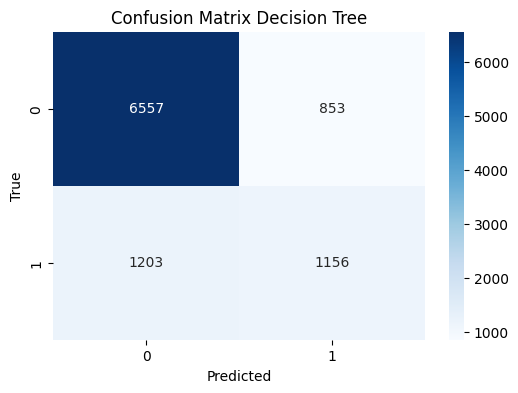

In [12]:
def dtc_classification():
  dtc = DecisionTreeClassifier(random_state=0)
  dtc = dtc.fit(X_train, y_train)
  y_pred = dtc.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)

  print("Decision tree classification")
  print(f"Accuracy: {accuracy * 100:.2f}%")
  plt.figure(figsize=(6, 4))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=df['income'].unique(), yticklabels=df['income'].unique())
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(f'Confusion Matrix Decision Tree')
  plt.show()

dtc_classification()

### K-nearest neighbors classification

K-nearest neighbors (KNN) classification is an algorithm that classifies a new data point by finding the k closest points to it in the training set and assigning it the class that occurs most frequently among those neighbors. The algorithm is based on the assumption that similar objects are located close to each other in the feature space, so it calculates distances between points and makes classification decisions based on "voting" by the nearest neighbors.

k-NN, k=15
Accuracy: 81.18%


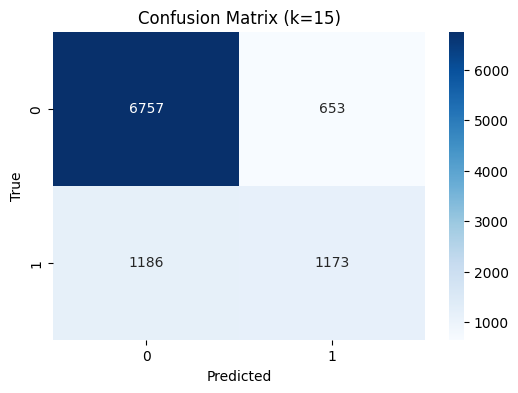

In [13]:
def knn_classification(k):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  
  y_pred = knn.predict(X_test)
  
  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)
  
  print(f"k-NN, k={k}")
  print(f"Accuracy: {accuracy * 100:.2f}%")

  plt.figure(figsize=(6, 4))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=df['income'].unique(), yticklabels=df['income'].unique())
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(f'Confusion Matrix (k={k})')
  plt.show()

knn_classification(15)

### Naive Bayes Classifier

Naive Bayes is a probabilistic classification algorithm based on Bayes' theorem that assumes independence between features (hence "naive") and calculates the probability of each class given the input features. The algorithm selects the class with the highest calculated probability by combining the prior probability of each class with the likelihood of observing the given feature values.

Naive Bayes classification
Accuracy: 77.14%


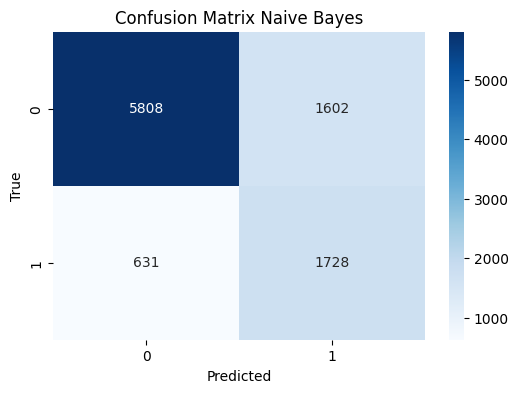

In [18]:
def naive_bayes_classification():
  gnb = GaussianNB()
  y_pred = gnb.fit(X_train, y_train).predict(X_test)
  misclassified = (y_test != y_pred).sum()
  total_points = X_test.shape[0]
  accuracy = ((total_points - misclassified) / total_points) * 100
  print("Naive Bayes classification")
  print(f"Accuracy: {accuracy:.2f}%")
  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df['income'].unique(), yticklabels=df['income'].unique())
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(f'Confusion Matrix Naive Bayes')
  plt.show()

naive_bayes_classification()

### MLP Classifier (Multilayer Perceptron)

I use a feedforward neural network, i.e., a multilayer perceptron (Multilayer Perceptron, MLP), for a network with two neural layers, one has 3 neurons, the other has 2 neurons.

Neural Network accuracy: 81.23%


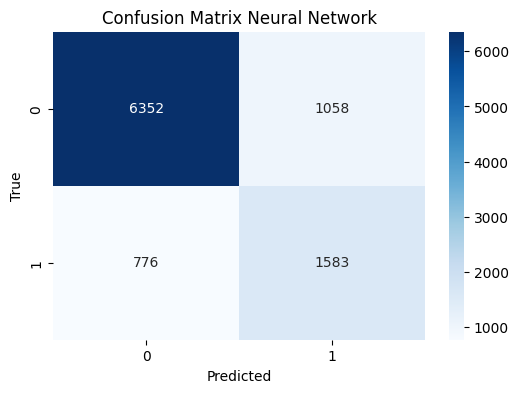

In [20]:
def mlp_neural_network_classifier():
  clf = MLPClassifier(hidden_layer_sizes=(3, 2), activation='relu', max_iter=500, random_state=1)

  clf.fit(X_train, y_train)
  prediction = clf.predict(X_test)

  print(f'Neural Network accuracy: {metrics.accuracy_score(prediction,y_test) * 100:.2f}%')
  cm = confusion_matrix(y_test, prediction)

  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df['income'].unique(), yticklabels=df['income'].unique())
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(f'Confusion Matrix Neural Network')
  plt.show()

mlp_neural_network_classifier()

### Classification using a neural network model

In this case, I performed classification using a self-configured and trained neural network model.

Epoch 1/100


c:\Users\kacpe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


570/570 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6340 - loss: 0.6158 - val_accuracy: 0.8153 - val_loss: 0.4092
Epoch 2/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8138 - loss: 0.3989 - val_accuracy: 0.8337 - val_loss: 0.3674
Epoch 3/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8214 - loss: 0.3725 - val_accuracy: 0.8344 - val_loss: 0.3587
Epoch 4/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8251 - loss: 0.3652 - val_accuracy: 0.8344 - val_loss: 0.3555
Epoch 5/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8281 - loss: 0.3638 - val_accuracy: 0.8348 - val_loss: 0.3535
Epoch 6/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8282 - loss: 0.3558 - val_accuracy: 0.8342 - val_loss: 0.3526
Epoch 7/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8280 - loss: 0.3599 - val_accuracy: 0.8344 - val_loss: 0.3509
Epoch 8/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8265 - loss: 0.3587 - val_accuracy: 0.8340

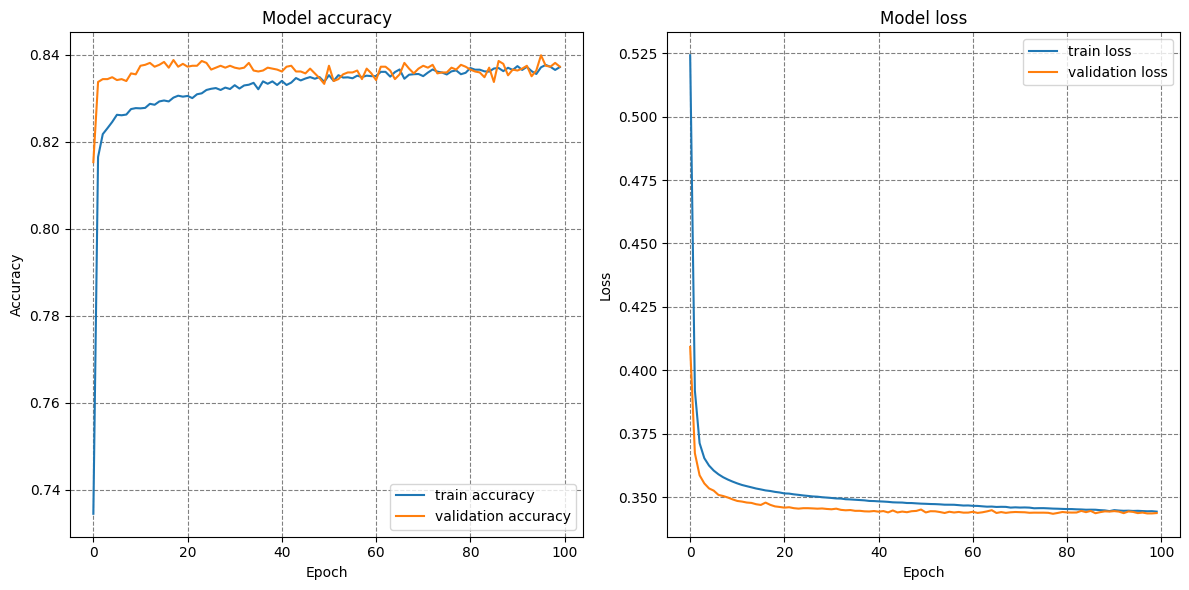

306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


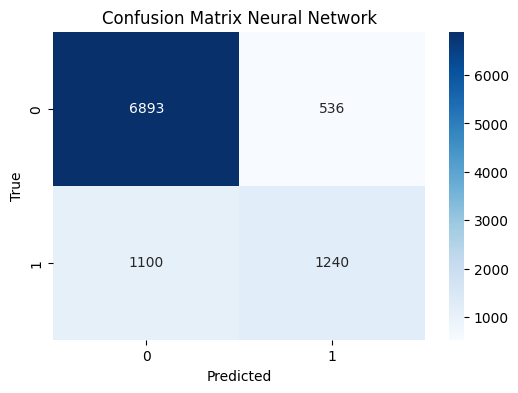

In [23]:
def keras_neural_network():
  y_array = np.array(y)
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  encoder = OneHotEncoder()
  y_encoded = encoder.fit_transform(y_array.reshape(-1, 1)).toarray()

  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

  model = Sequential([
      Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
      Dense(64, activation='relu'),
      Dense(y_encoded.shape[1], activation='softmax')
  ])

  model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

  history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

  test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
  print(f"Test Accuracy: {test_accuracy*100:.2f}%")

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='train accuracy')
  plt.plot(history.history['val_accuracy'], label='validation accuracy')
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.grid(True, linestyle='--', color='grey')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='validation loss')
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.grid(True, linestyle='--', color='grey')
  plt.legend()

  plt.tight_layout()
  plt.show()

  y_pred = model.predict(X_test)
  y_pred_classes = np.argmax(y_pred, axis=1)

  cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df['income'].unique(), yticklabels=df['income'].unique())
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title(f'Confusion Matrix Neural Network')
  plt.show()

keras_neural_network()

The model accuracy is: 83.25%

Above are the learning curves. We can read from them the accuracy and loss of the model during training and validation over 100 epochs.

#### Network Information:

This neural network has a Sequential architecture with three Dense layers - two hidden layers with 64 neurons each with ReLU activation function and an output layer with softmax activation for multi-class classification. The model is trained for 100 epochs using SGD (Stochastic Gradient Descent) optimizer and binary_crossentropy loss function. During training, 20% of the training data is used for validation, and the input data is normalized using StandardScaler, while the labels are encoded using one-hot encoding.

## 5. Summary

The project involved a comparative analysis of various classification techniques to predict income levels based on demographic and socio-economic data from the Adult Census Income database. The main task was to determine whether a given person earns above or below $50,000 annually. Five different classification methods were tested, where neural networks proved to be the most effective, achieving over 83% accuracy. The difference between the worst (Naive Bayes - 77.14%) and best (neural network - 83.25%) results was over 6 percentage points, confirming the importance of selecting the appropriate algorithm.